##Word2Vec
skipgram with negative selection (SGNS)

In [ ]:
import pandas as pd
import numpy as np
import nltk #불용어 처리를 위한 nltk 로드
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups #사용할 데이터셋 
from tensorflow.keras.preprocessing.text import Tokenizer #단어를 토큰화하기 위한 Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


빈 값을 null 값으로 변환

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

Null 값 제거

In [ ]:
news_df.dropna(inplace=True) 
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


불용어 제거

In [ ]:
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

1개 이하인 단어 삭제

In [ ]:
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


단어들을 토큰화

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index #단어를 index화 시킨다 각각 숫자부여
idx2word = {value : key for key, value in word2idx.items()} #
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
print(encoded[:2])  #문장을 단어들로 token화시킴 2문장을 예로 뽑아 놓은 것

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


단어의 총 크기

In [ ]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


skip gram을 적용

In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

임베딩 계층을 추가 2개(하나는 중심단어, 하나는 맥락단어)

In [ ]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

임베딩 계층간 dot product를 하기 위해서 모델을 만들어줍니다.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

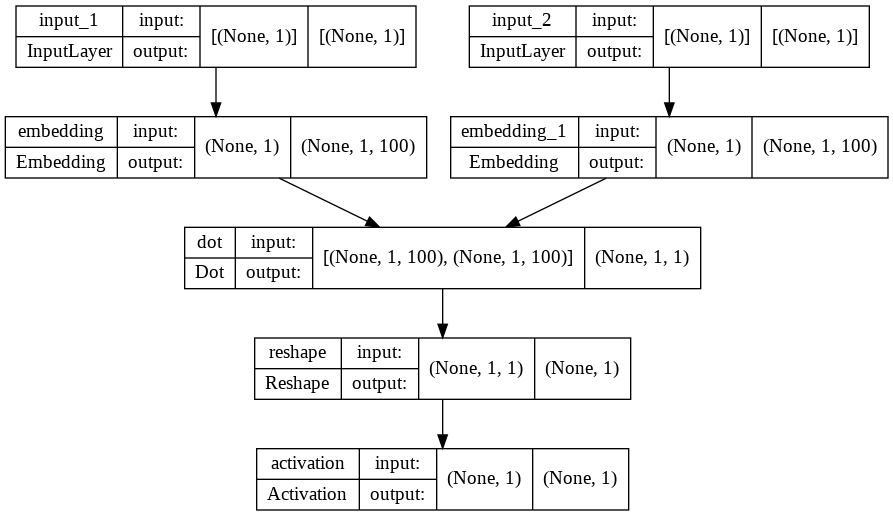

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])  #word embedding, context embedding간 내적   
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product) #이걸 가지고 Reshape
output = Activation('sigmoid')(dot_product) #위의 결과를 sigmoid로 집어넣음

model = Model(inputs=[w_inputs, c_inputs], outputs=output) #input 중심단어 embedding, 맥락단어 embedding만큼 주어진다.
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam') #binary cross entropy 사용, adam 으로 최적화
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

5 epoch로 진행

In [ ]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4634.509464386851
Epoch : 2 Loss : 3661.5545852705836
Epoch : 3 Loss : 3499.7571209240705
Epoch : 4 Loss : 3300.989577624947
Epoch : 5 Loss : 3076.3239673841745


In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, 100))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
def analogy(x1,x2,y1):
  result = w2v.most_similar(positive = [y1,x2],negative = [x1])
  return result[0][0]

In [ ]:
w2v.most_similar(positive=['soldiers'])

[('baku', 0.8653351068496704),
 ('inhabitants', 0.8565704226493835),
 ('gulf', 0.8419508934020996),
 ('massacred', 0.8384090065956116),
 ('israelis', 0.8351427316665649),
 ('suffered', 0.8335262537002563),
 ('brutally', 0.8333600759506226),
 ('slaughtered', 0.8327736854553223),
 ('homes', 0.8323044180870056),
 ('raped', 0.8254745006561279)]

In [ ]:
w2v.most_similar(positive=['doctor'])

[('medication', 0.6732416152954102),
 ('patient', 0.6699470281600952),
 ('sinless', 0.6616228818893433),
 ('pain', 0.6546023488044739),
 ('migraine', 0.6477897763252258),
 ('clinic', 0.623313307762146),
 ('doctors', 0.6213982701301575),
 ('hypertension', 0.6080249547958374),
 ('medicine', 0.6059878468513489),
 ('chronic', 0.6059637665748596)]

In [ ]:
analogy('doctor','doctors','teacher')

'policeman'